<a href="https://colab.research.google.com/github/Nanabewbew/Data-Analysis-on-glucose-sensor/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving DataSheet_Final.xlsx to DataSheet_Final (4).xlsx
DataFrame shape (rows, columns): (889, 20)
Target y shape: (889,)
First few target values:
 0    0.00638
1    0.00638
2    0.01368
3    0.01368
4    0.02451
Name: Peak Current (mA), dtype: float32
Processed X shape: (889, 125)
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0456 - mae: 0.1205 - val_loss: 0.0251 - val_mae: 0.0770
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0300 - mae: 0.0749 - val_loss: 0.0222 - val_mae: 0.0607
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0136 - mae: 0.0421 - val_loss: 0.0209 - val_mae: 0.0547
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - mae: 0.0464 - val_loss: 0.0208 - val_mae: 0.0572
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - mae: 0.0387 - val_loss: 0.0179 - val_mae: 0.0487
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mae: 0.0460 - val_loss: 0.0164 - val_mae: 0.0522
Epoch 7/100


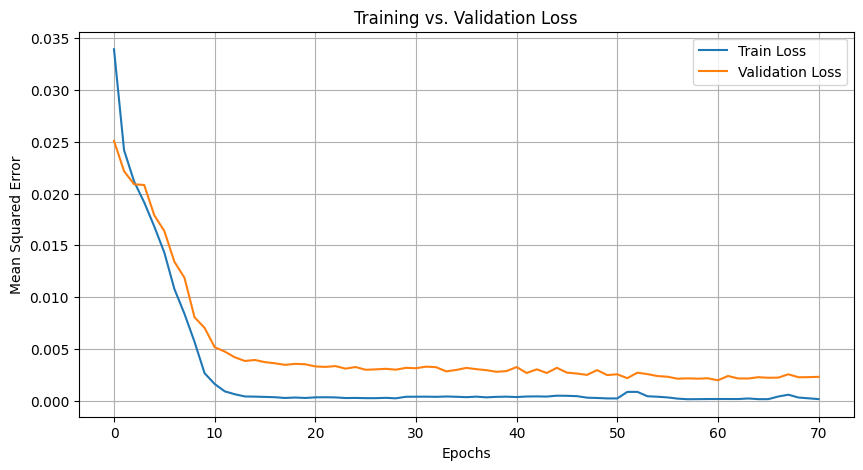

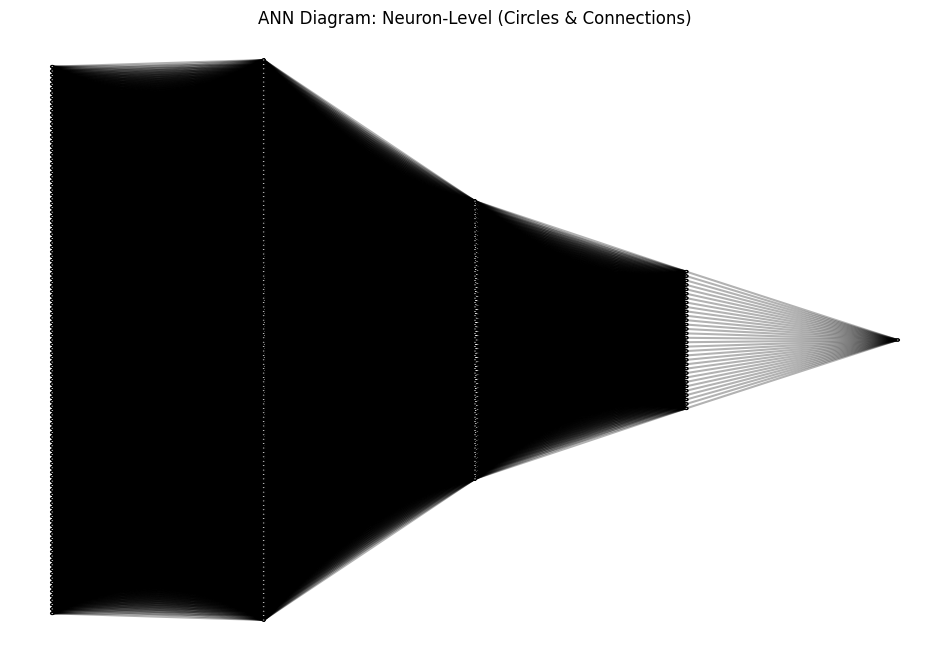

In [ ]:

!pip install -q openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
uploaded = files.upload()

filename = next(iter(uploaded.keys()))
df = pd.read_excel(filename, engine='openpyxl')

print("DataFrame shape (rows, columns):", df.shape)
if df.shape[0] == 0:
    raise ValueError("Your DataFrame is empty. Please check your Excel file.")

df.columns = df.columns.astype(str)

target_column = "Peak Current (mA)"
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found in DataFrame columns: {df.columns.tolist()}")

X = df.drop(columns=[target_column])
y = df[target_column]

y = y.astype(str).str.replace('−', '-', regex=False)
y = pd.to_numeric(y, errors='coerce').astype("float32")

print("Target y shape:", y.shape)
print("First few target values:\n", y.head())

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)

numerical_cols = [col for col in X.columns if col not in categorical_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

X_processed = preprocessor.fit_transform(X)
print("Processed X shape:", X_processed.shape)
if X_processed.shape[0] == 0:
    raise ValueError("Processed X has 0 rows. Check your imputation and input data.")

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],), name="Input"),
    Dense(128, activation='relu', name="Hidden1"),
    Dense(64, activation='relu', name="Hidden2"),
    Dense(32, activation='relu', name="Hidden3"),
    Dense(1, name="Output")
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

def draw_neural_net(ax, layer_sizes):
    """
    Draws a simple neural network diagram with circles (neurons) and lines (connections).

    Parameters:
        ax (matplotlib.axes.Axes): The axes to draw on.
        layer_sizes (list): A list containing the number of neurons in each layer.
    """
    n_layers = len(layer_sizes)
    v_spacing = 1.0 / max(layer_sizes)
    h_spacing = 1.0 / (n_layers - 1)
    neuron_coords = []

    for i, n_neurons in enumerate(layer_sizes):
        layer_coords = []
        y_top = 0.5 - (n_neurons - 1) * v_spacing / 2.0
        for j in range(n_neurons):
            x = i * h_spacing
            y = y_top + j * v_spacing
            layer_coords.append((x, y))
            circle = plt.Circle((x, y), v_spacing/4, color='w', ec='k', zorder=4)
            ax.add_artist(circle)
        neuron_coords.append(layer_coords)

    for i in range(n_layers - 1):
        for (x1, y1) in neuron_coords[i]:
            for (x2, y2) in neuron_coords[i+1]:
                ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

layer_sizes = [X_train.shape[1], 128, 64, 32, 1]
fig, ax = plt.subplots(figsize=(12, 8))
draw_neural_net(ax, layer_sizes)
ax.set_title("ANN Diagram: Neuron-Level (Circles & Connections)")
ax.axis('off')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DataSheet_Final.xlsx to DataSheet_Final (3).xlsx


In [ ]:
df = pd.read_excel(next(iter(uploaded)), engine='openpyxl')

In [ ]:
df.columns = df.columns.astype(str)

In [ ]:
target_column = "Peak Current (mA)"

# Separate X and y BEFORE imputing
X = df.drop(columns=[target_column])
y = df[target_column]

# For the target, if needed, fix any non-standard minus signs and convert to float
y = y.astype(str).str.replace('−', '-', regex=False)
y = pd.to_numeric(y, errors='coerce').astype("float32")

# Now, do imputation and encoding for features
# First, ensure all categorical columns are strings:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Numerical columns: any column not in categorical list
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Build preprocessing pipelines for numeric and categorical features:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Apply the preprocessing pipelines
X_processed = preprocessor.fit_transform(X)

# Print the shape to confirm we have data
print("Processed X shape:", X_processed.shape)
print("Target y shape:", y.shape)

ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required by SimpleImputer.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Model Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def draw_neural_net(ax, layer_sizes):
    n_layers = len(layer_sizes)
    v_spacing = 1.0 / max(layer_sizes)
    h_spacing = 1.0 / (n_layers - 1)
    neuron_coords = []

    for i, n_neurons in enumerate(layer_sizes):
        layer_coords = []
        y_top = 0.5 - (n_neurons - 1) * v_spacing / 2.0
        for j in range(n_neurons):
            x = i * h_spacing
            y = y_top + j * v_spacing
            layer_coords.append((x, y))
            circle = plt.Circle((x, y), v_spacing/4, color='w', ec='k', zorder=4)
            ax.add_artist(circle)
        neuron_coords.append(layer_coords)

    for i in range(n_layers - 1):
        for (x1, y1) in neuron_coords[i]:
            for (x2, y2) in neuron_coords[i+1]:
                ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

In [ ]:
layer_sizes = [X_train.shape[1], 128, 64, 32, 1]  # Based on model architecture
fig, ax = plt.subplots(figsize=(12, 8))
draw_neural_net(ax, layer_sizes)
ax.set_title("Artificial Neural Network Architecture")
ax.axis('off')
plt.show()